In [5]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import gridspec
from scipy import stats
import pandas as pd
import scipy.signal as ss
import re
from burst_utils import find_burst, boxcar_kernel
from astropy import modeling
from astropy.modeling import models, fitting
import matplotlib
from lmfit.models import ExponentialGaussianModel, ExponentialModel, GaussianModel
import math
from scipy.signal import convolve
import sys,os
from bokeh.models import ColumnDataSource, Div
MIN_FLOAT = sys.float_info[3]
from scipy.optimize import curve_fit

In [6]:
#Formatting
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [7]:
def get_mad(ts):
    return np.median(np.abs(ts - np.median(ts)))

def normalise(ts):
    return ts/(1.4826*get_mad(ts))

def Gaussian1D(x,sig,x0):
    return np.exp(-(x-x0)*(x-x0)/(2*sig*sig + MIN_FLOAT))

def linear(x,a,b):
    return a*x + b

def exp_decay(x,tau,x0):
    res = np.zeros(len(x)) + MIN_FLOAT
    #res[x <= x0] = MIN_FLOAT
    res[x > x0] = np.exp(-(x[x>x0]-x0)/(tau+MIN_FLOAT))
    return res

def exp_gauss(x,x0,amp,sig,tau,eps):
    gx0 = np.mean(x)
    g = Gaussian1D(x,sig,gx0)
    ex = exp_decay(x,tau,x0)
    conv = convolve(g,ex,"same")
    conv /= np.max(conv) + MIN_FLOAT
    return amp*conv + eps

def exp_gauss_4(x,x1,amp1,sig1,tau1,
               x2,amp2,sig2,tau2,
               x3,amp3,sig3,tau3,
               x4,amp4,sig4,tau4):
    g1 = exp_gauss(x,x1,amp1,sig1,tau1,0)
    g2 = exp_gauss(x,x2,amp2,sig2,tau2,0)
    g3 = exp_gauss(x,x3,amp3,sig3,tau3,0)
    g4 = exp_gauss(x,x4,amp4,sig4,tau4,0)
    return g1 + g2 + g3 + g4


def lnlike(theta, x, y):
    model = exp_gauss_4(x,*theta)
#    inv_sig = 1./(model**2)
    chisqr = -0.5*(np.sum((y-model)**2))
    return chisqr

def sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency):
    
    npy = np.load(npy_fil)
    npy_sub = np.flipud(np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1))
    timeseries = npy_sub.sum(0)

    return npy, npy_sub, timeseries

In [23]:
#Load npy
#npy_fil = 'A_117_dm348.8.fits.npy'
#npy_fil = 'B_686_dm348.8.fits.npy'
#npy_fil = 'C_1164_dm348.8_lores.npy'
#npy_fil = 'D_267_dm348.8_lores.npy'
#npy_fil = 'E_579_dm348.8.fits.npy'
#npy_fil = 'F_639_dm348.8.fits.npy'
#npy_fil = 'G_1549_dm348.8.fits.npy'
#npy_fil = 'GMRT_A.dynamicspec_348.8.npy'
#npy_fil = 'GMRT_B.dynamicspec_349.19.npy'
#npy_fil = 'GMRT_C.dynamicspec_350_scrunch20.npy'
npy_fil = 'GMRT_D.dynamicspec_349.19_scrunch4.npy'

x = np.load(npy_fil)


In [24]:
subfactor = 1
#bandwidth = 400. #MHz
#center_frequency = 800. #MHz
#file_duration = 83.33 #ms
#GBTC
#file_duration = 333.33
#GBTD
#file_duration = 166.68

bandwidth = 200.
center_frequency = 400.
##GMRT A
##file_duration = 163.84
#GMRT B
file_duration = 122.88

In [25]:
npy, npy_sub, timeseries = sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency)
peaks, widths, snrs = find_burst(timeseries)
sampling_time = (file_duration / npy.shape[1])
nchan = npy.shape[0]
freq_res = bandwidth / nchan
print('Sampling Time (ms): ', sampling_time)
print(peaks, widths)
print(npy.shape)

Sampling Time (ms):  0.16383999999999999
451 28
(64, 750)


In [26]:
#Resolutions
tres = file_duration / npy.shape[1]
print('Raw Time Resolution (microsec): ', tres*1e3)
nchan = npy.shape[0]
fres = bandwidth / nchan
print('Raw Frequency Resolution (kHz): ', fres*1e3)

Raw Time Resolution (microsec):  163.83999999999997
Raw Frequency Resolution (kHz):  3125.0


In [27]:
#Shape Check
print('Array Shape:', npy.shape)

Array Shape: (64, 750)


In [28]:
#Define windowing depending on where burst sits in dynspec
window_left = int(peaks - 1*widths)
print(window_left)
window_right = int(peaks + 1*widths)
print(window_right)

if window_right - window_left <= 100:
    window_right = window_right + 300
    window_left = window_left - 300

print(window_left)
print(window_right)

423
479
123
779


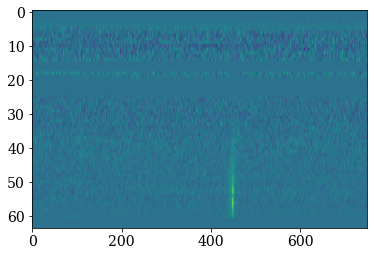

In [29]:
plt.imshow(npy_sub, aspect = 'auto')

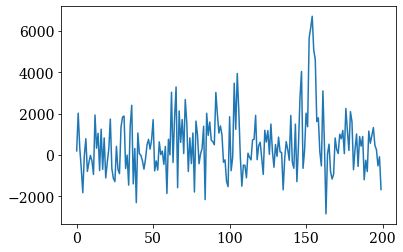

In [22]:
plt.plot(npy_sub.sum(0))

In [108]:
y_data = (npy[:, window_left:window_right].sum(0)/np.max(npy[:, window_left:window_right].sum(0)))
x = np.arange(len(y_data)) * sampling_time

In [109]:
#GBTA
p0 = [1.51, 0.38, 0.18, 1.44,
      0.001, 0.001, 0.001, 0.001,
      0.001, 0.001, 0.001, 0.001,
      0.001, 0.001, 0.001, 0.001]

##GBTB
#p0 = [4.63, 0.55, 0.78, 0.26,
#      5.03, 0.31, 0.14, 0.27,
#      5.73, 0.34, 0.18, 0.45,
#      6.32, 0.26, 0.21, 1.35]

#GBTC
#p0 = [62.40, 0.60, 1.57, 1.32,
#      0.01, 0.01, 0.01, 0.01,
#      0.01, 0.01, 0.01, 0.01,
#      0.01, 0.01, 0.01, 0.01]

#GBTD
#p0 = [26.08, 0.62, 1.00, 1.02,
#      0.001, 0.001, 0.001, 0.001,
#      0.001, 0.001, 0.001, 0.001,
#      0.001, 0.001, 0.001, 0.001,]
#GBTE
#p0 = [2.48, 0.76, 0.61, 0.10,
#    3.44, 0.72, 0.34, 0.40,
#    4.17, 0.55, 0.24, 1.13,
#     0.0, 0.0, 0.0, 0.0]

#GBTF
#p0 = [7.98, 0.43, 0.41, 0.06,
#      8.95, 0.39, 0.38, 2.77,
#      11.57, 0.25, 0.14, 1.19,
#      13.93, 0.12, 0.05, 0.86]
#
#GBTG
p0 = [14.87, 0.29, 0.54, 0.09,
      15.72, 0.38, 1.36, 3.34,
      19.97, 0.32, 0.64, 3.57,
      27.14, 0.23, 0.20, 2.58]
#
##GMRTA
#p0 = [11.84, 0.78, 2.18, 0.10,
#    16.92, 0.81, 1.62, 0.46,
#    19.98, 0.36, 0.70, 4.95,
#     0.01, 0.01, 0.01, 0.01]
#
##GMRTB
#p0 = [5.84, 0.96, 0.74, 1.91,
#      0.01, 0.01, 0.01, 0.01,
#      0.01, 0.01, 0.01, 0.01,
#      0.01, 0.01, 0.01, 0.01]

p0 = [i*(83.33/166.68) for i in p0]
print(p0)
p0 = [7.43, 0.29, 0.27, 0.045, 
      7.86, 0.38, 0.68, 1.67, 
      9.98, 0.32, 0.32, 1.78, 
     13.57, 0.23, 0.10, 1.29]

[7.434107871370289, 0.14498260139188862, 0.26996760259179264, 0.04499460043196544, 7.859056875449964, 0.18997720182385408, 0.6799184065274778, 1.6697996160307174, 9.98380189584833, 0.15998080153587713, 0.31996160307175425, 1.784785817134629, 13.568371730261578, 0.11498620110391168, 0.0999880009599232, 1.2898452123830093]


In [110]:
low = [(i - 1) for i in p0]
up = [(i + 1) for i in p0]

print(list(low))

[6.43, -0.71, -0.73, -0.955, 6.86, -0.62, -0.31999999999999995, 0.6699999999999999, 8.98, -0.6799999999999999, -0.6799999999999999, 0.78, 12.57, -0.77, -0.9, 0.29000000000000004]


In [111]:
x = np.arange(len(y_data)) * sampling_time
y = exp_gauss_4(x, *p0)
lnlike_val = lnlike(p0, x, y_data)
lnlikebox = Div(text="",width=800)

In [112]:
popt, pcov = curve_fit(exp_gauss_4, x, y, p0, bounds = (low, up))
print('Optimized Fit Parameters: ', popt)

Optimized Fit Parameters:  [ 7.43   0.29   0.27   0.045  7.86   0.38   0.68   1.67   9.98   0.32
  0.32   1.78  13.57   0.23   0.1    1.29 ]


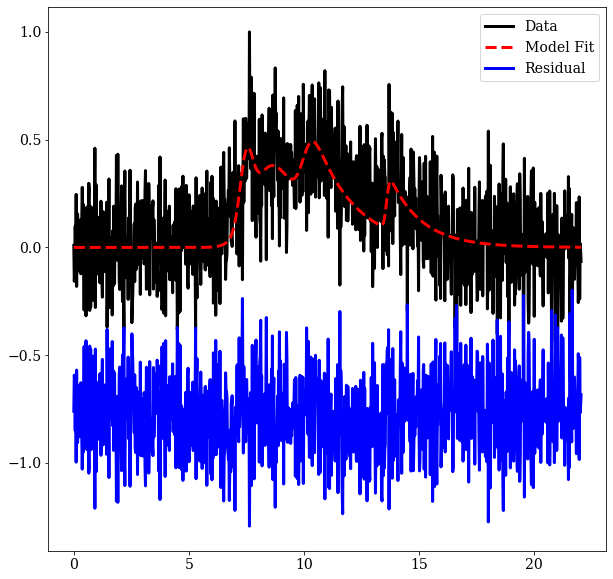

In [113]:
fig = plt.figure(figsize = (10, 10))
plt.plot(x, y_data, label = 'Data', linewidth = 3, c = 'k')
plt.plot(x, y, label = 'Model Fit', linewidth = 3, c = 'r', linestyle = 'dashed')
plt.plot(x, y-y_data-0.75, c = 'b', linewidth = 3, label = 'Residual')
plt.legend()

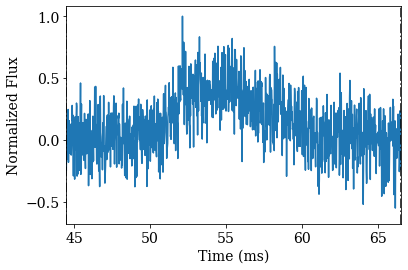

In [239]:
fig = plt.figure()
time = np.linspace(0, len(timeseries), len(timeseries))
timeseries_norm = timeseries/np.max(timeseries)
plt.plot(time*tres, timeseries_norm)
#plt.axvline(peaks, c = 'r', linestyle = 'dotted')
plt.axvline(window_left*tres, c = 'k', linestyle = 'dashdot')
plt.axvline(window_right*tres, c = 'k', linestyle = 'dashdot')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Flux')
plt.xlim(window_left*tres, window_right*tres)
plt.show()

In [76]:
#Crop
time_zoom = np.linspace(0, round(window_right - window_left), round(window_right - window_left))
timeseries_zoom = timeseries_norm[window_left:window_right]

[245  74 351]


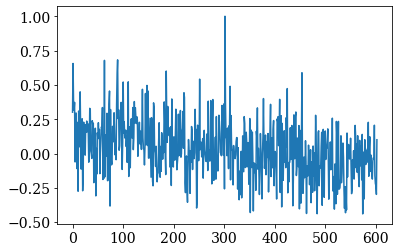

In [77]:
plt.plot(time_zoom, timeseries_zoom)
#convolved = ss.convolve(timeseries_zoom, boxcar_kernel(60))
#convolved = convolved/np.max(convolved)
#plt.plot(convolved/np.max(convolved))

#Find Peaks for Fitting
peaks = ss.find_peaks(timeseries_zoom)[0]
prominences = ss.peak_prominences(timeseries_zoom, peaks)
#print(prominences)
#Get top 3 most prominent peaks
main_peaks = prominences[1][prominences[0].argsort()[-3:][::-1]]
plt.plot()
print(main_peaks)

Model: Exponential1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             tau        
    ------------------- ------------------
    0.08527495662242121 -60.71164898575614
Scattering Timescale (ms): 1.2351322534138327+/-1.0374402814599817


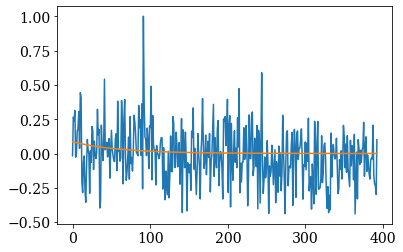

In [78]:
#Fit to scattering tail

timeseries_exp = timeseries_zoom[210:]
time_exp = np.linspace(0, len(timeseries_exp), len(timeseries_exp))
fitter_exp = modeling.fitting.LevMarLSQFitter()
model_exp = modeling.models.Exponential1D(amplitude=np.max(timeseries_exp), tau=-169.)
fitted_model_exp = fitter_exp(model_exp, time_exp, timeseries_exp)
print(fitted_model_exp)
tau_unc = np.sqrt(np.diag(fitter_exp.fit_info['param_cov']))[1]/fitted_model_exp.tau[0]
halfmax = fitted_model_exp.amplitude[0] / math.e
hm_idx = (np.abs(timeseries_exp-halfmax)).argmin()
t_idx = np.where(timeseries_exp == timeseries_exp[hm_idx])[0][0]
hm = time_exp[t_idx]*tres
scat_ts = np.abs(fitted_model_exp.tau[0]*tres)
scat_ts_unc = np.abs(scat_ts*tau_unc)

print('Scattering Timescale (ms): ' + str(scat_ts) + '+/-' + str(scat_ts_unc))

plt.plot(time_exp, timeseries_exp)
plt.plot(time_exp, fitted_model_exp(time_exp))

In [26]:
print('Fitter Message: ')
#gauss_exp_init = models.Gaussian1D(0.8, main_peak, 20.)+ models.Gaussian1D(1.2, 220, 40.) + models.Exponential1D(1., -53.)
gauss_exp_init = models.Gaussian1D(0.8, 40, 5.) +  models.Gaussian1D(0.8, 115, 5.) + models.Exponential1D(0.6, fitted_model_exp.tau[0])
fitter = modeling.fitting.LevMarLSQFitter()
gauss_exp_fit = fitter(gauss_exp_init, time_zoom, timeseries_zoom)
print(fitter.fit_info['message'])
print(gauss_exp_fit)

Fitter Message: 
Number of calls to function has reached maxfev = 100.
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=-0.17948307, mean=55.90851474, stddev=32.64353954)>

    [1]: <Gaussian1D(amplitude=0.84088832, mean=169.62858422, stddev=69.3431886)>

    [2]: <Exponential1D(amplitude=0.03780213, tau=-807.65084237)>
Parameters:
        amplitude_0            mean_0       ...       tau_2       
    -------------------- ------------------ ... ------------------
    -0.17948307455086027 55.908514743584284 ... -807.6508423665562


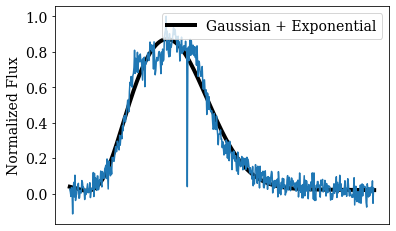

In [27]:
plt.plot(time_zoom, gauss_exp_fit(time_zoom), linewidth = 4, c = 'black', \
         label = 'Gaussian + Exponential')
         #label = 'Double Gaussian + Exponential')
plt.plot(timeseries_zoom)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Normalized Flux')
plt.legend()

In [ ]:
print()

[6.76971644e-01 1.28151904e+02 5.80247311e+01 4.00000000e+02
 4.40020000e+04]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> 425 425


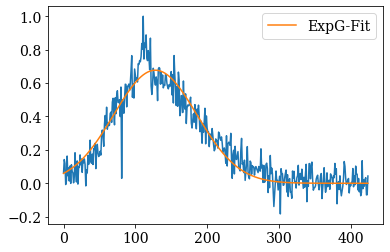

In [205]:
import numpy as npy
import scipy as sp
import pylab as py
import scipy.optimize as opt

def expBroaden(y, t, expMod):
    fy = np.fft.fft(y)
    a = np.exp(-1*expMod*np.arange(0,len(y))/t)
    fa = np.fft.fft(a)
    fy1 = fy*fa
    yb = (np.fft.ifft(fy1).real)/np.sum(a)
    return yb

def expGauss(x, pos, wid, tConst, expMod = 0.5, amp = 1):

    '''
    x -- numpy array
    pos -- centroid position
    wid -- width
    tConst -- time constance for exponential decay
    amp -- amplitude of peak
    expMod -- modifies the amplitude of the peak -- must be a float

    Forumulas used:

    y = a * exp(-0.5 * (x-b)^2 / c^2) --traditional gaussian forumla
    exp = N.exp(-1*expMod*N.arange(0,len(y))/Const) --function that is merged with the gaussian

    Note if expMod is too small (i.e. goes towards zero) the function will return a flat line.
    '''
    expMod *=1.0
    gNorm = amp * np.exp(-0.5*((x-pos)/(wid))**2)
    g = expBroaden(gNorm, tConst, expMod)
    return g, gNorm


#a = np.arange(0,100,0.1)

#tConstArray = np.arange(10,200,10)
#x, x1 = expGauss(a, 50, 2, 150, 2, 5)
#xN = x + 0.5-sp.rand(len(a))/2
#x1N = x1 + 0.5-sp.rand(len(a))/2

a = time_zoom
xN = timeseries_zoom


'def expGauss(x, pos, wid, tConst, expMod = 0.5, amp = 1):'

#p[0] -- amplitude, p[1] -- position, p[2] -- width, p[3]--tConst, p[4] -- expMod

fitfuncExpG = lambda p, x: expGauss(x, p[1], p[2], p[3], p[4], p[0])[0]
errfuncExpG = lambda p, x, y: fitfuncExpG(p, x) - y # Distance to the target function
p0a = [0.9, 228., 41., 400., 44002.] # Initial guess for the parameters
p1a, success = opt.leastsq(errfuncExpG, p0a[:], args=(a, xN))
p1aG = fitfuncExpG(p1a,a)

print(p1a)

print(type(xN), type(a), len(xN), len(a))
#plt.plot(xN, 'go', alpha = 0.4, label = "ExpGaussian")
plt.plot(xN)
plt.plot(p1aG, label = 'ExpG-Fit')

plt.legend()
plt.show()

In [209]:
#!/usr/bin/env python

from scipy.optimize import leastsq
from numpy import *
from pylab import *
from scipy import *
from scipy import optimize
import numpy as N
import pylab as P

time = time_zoom
rate = timeseries_zoom

def expGauss(x, pos, wid, tConst, expMod = 0.5, amp = 1):
    expMod *= 1.0
    gNorm = amp * N.exp(-0.5*((x-pos)/(wid))**2)
    g = expBroaden(gNorm, tConst, expMod)
    return g, gNorm

def expBroaden(y, t, expMod):
    fy = F.fft(y)
    a = N.exp(-1*expMod*time/t)
    fa = F.fft(a)
    fy1 = fy*fa
    yb = (F.ifft(fy1).real)/N.sum(a)
    return yb

if __name__ == '__main__':

# Fit the first set
#p[0] -- amplitude, p[1] -- position, p[2] -- width
    fitfuncG = lambda p, x: p[0]*N.exp(-0.5*(x-p[1])**2/p[2]**2) # Target function
    errfuncG = lambda p, x, y: fitfuncG(p, x) - y # Distance to the target function
    p0 = [0.20, 56210, 2.0] # Initial guess for the parameters
    p1, success = optimize.leastsq(errfuncG, p0[:], args=(time, rate))
    p1G = fitfuncG(p1, time)
   # P.plot(rate,  'ro', alpha = 0.4, label = "Gaussian")
   # P.plot(p1G, label = 'G-Fit')

def expGauss(x, pos, wid, tConst, expMod = 0.5, amp = 1):
  #p[0] -- amplitude, p[1] -- position, p[2] -- width, p[3]--tConst, p[4] -- expMod  
    fitfuncExpG = lambda p, x: expGauss(x, p[1], p[2], p[3], p[4], p[0])[0]
    errfuncExpG = lambda p, x, y: fitfuncExpG(p, x) - y # Distance to the target function  
    p0a = [0.20, 56210, 2.0] # Initial guess for the parameters
    p1a, success = optimize.leastsq(errfuncExpG, p0a[:], args=(time, rate))
    p1aG = fitfuncExpG(p1a, time)
    P.plot(rate, 'go', alpha = 0.4, label = "ExpGaussian")  
    P.plot(p1aG, label = 'ExpG-Fit')

    P.legend()  
    P.show()

/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  if __name__ == '__main__':
/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  # Remove the CWD from sys.path while we load stuff.


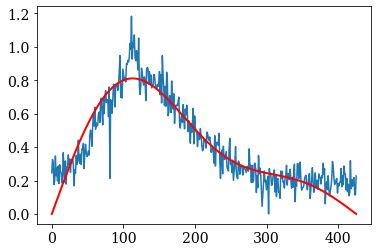